In [105]:
from pygsp import graphs, filters
import pyunlocbox
import numpy as np
import pandas as pd

%matplotlib inline

In [84]:
from matplotlib import pyplot as plt

In [117]:
adjacency_matrix = np.load("processed_data/coexpression_adjacency.npy")
node_indices = np.load("processed_data/coexpression_node_indices.npy")
expression_data = pd.read_pickle("processed_data/expression_data.pkl")
selected_features = pd.read_pickle("processed_data/selected_features.pkl")

We use the coexpression graph with signal set to SNP expression with missing values set to mean. For each mouse we apply Tikhonov regularization for imputation.

In [96]:
G = graphs.Graph(adjacency_matrix)
G.set_coordinates()

In [118]:
mice_with_susceptibility = selected_features.index.tolist()
expression_with_susceptibility = expression_data.iloc[node_indices].T

In [119]:
na_df = expression_with_susceptibility.isna()

In [143]:
expression_with_susceptibility.fillna(0, inplace=True)

We draw a graph to make sure that there is certain smoothness present - this validates our method of constructing graph and justifies using Tikhonov regularization.

We can see groups of darker and groups of brighter nodes, which shows that indeed some of the SNPs close according to our distance coexpress.

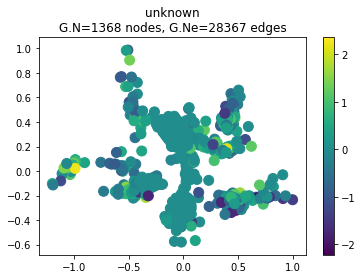

In [187]:
label_signal = expression_with_susceptibility.values[50, :]
fig = G.plot_signal(label_signal)

In [304]:
L = G.D.toarray()
r = pyunlocbox.functions.norm_l2(A=L, tight=False)

def tikhonov_regularize(label_signal, gamma=0.001):
    step = 0.999 / np.linalg.norm(np.dot(L.T, L) + gamma, 2)
    solver = pyunlocbox.solvers.gradient_descent(step=step)
    x0 = label_signal.copy()
    f = pyunlocbox.functions.norm_l2(y=label_signal,
                                      lambda_=gamma)
    prob2 = pyunlocbox.solvers.solve([r, f], solver=solver,
                                         x0=x0, rtol=0, maxit=1000)
    return prob2["sol"]

We tune the parameters, especially gamma, to have some of the missing expression values updated considerably (by at least 0.5 where $\sigma=1$) and at the same time to keep the error for the known values small.

Solution found after 1000 iterations:
    objective function f(sol) = 2.921622e-01
    stopping criterion: MAXIT


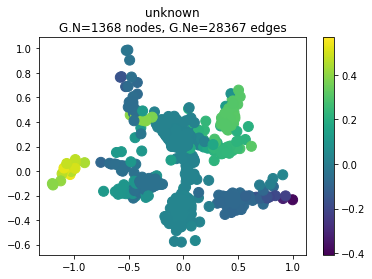

In [305]:
label_signal = expression_with_susceptibility.values[50, :]
solution = tikhonov_regularize(label_signal)
G.plot_signal(solution)

Maximal value of the inferred expression:

In [306]:
max(abs(solution[na_df.values[50]]))

0.4676223077488322

Average error per node:

In [307]:
error = (abs(label_signal[~na_df.values[50]] - solution[~na_df.values[50]])).sum()
number_of_known = (~na_df.values[50]).sum()
error/number_of_known

0.559704828869552

We iterate for all mice to perform imputation.

In [ ]:
import time
gamma = 0.001
inferred = np.zeros_like(expression_with_susceptibility.values)
start_time = time.time()

for mouse_id in range(inferred.shape[0]):
    label_signal = expression_with_susceptibility.values[mouse_id, :]
    solution = tikhonov_regularize(label_signal)
    inferred[mouse_id] = solution

    time_elapsed = time.time() - start_time
    time_total = inferred.shape[0]/(mouse_id + 1) * time_elapsed
    print(f"{mouse_id + 1} mouse. {time_elapsed/60}m/{time_total/60}m")

np.save(f"processed_data/inferred_{gamma}.npy", inferred)

In [296]:
inferred = np.load(f"processed_data/inferred_{gamma}.npy")
# we scale the inferred expression values to have standard deviation 1, like the original data
for col in range(inferred.shape[1]):
    inferred[:, col] = inferred[:, col] / np.std(inferred[na_df.iloc[:, col]])
# fill in missing values
expression_full = pd.read_pickle("processed_data/expression_data.pkl")
expression_full = expression_full.iloc[node_indices].T
expression_full.values[na_df] = inferred[na_df]

In [297]:
malaria_susceptibility = pd.read_pickle("processed_data/malaria_susceptibility.pkl")

In [298]:
not_inferred = [i for i in range(1982) if i not in node_indices]

In [299]:
expression_full_susceptibility = pd.DataFrame(malaria_susceptibility.iloc[:,-1]).join(expression_full)\
                                                                                .join(selected_features.iloc[:,not_inferred]).fillna(0)

In [300]:
X_train, y_train = expression_full_susceptibility.iloc[:,1:], expression_full_susceptibility.iloc[:,0]

In [361]:
from sklearn.linear_model import RidgeCV
def evaluate_ridge(X_train_eval, y_eval, upper_alpha_limit=20):
    clf_ridge_relevant = RidgeCV(alphas=np.linspace(1e-10, upper_alpha_limit, 50), store_cv_values=True).fit(X_train_eval, y_eval)
    print(f"best alpha: {clf_ridge_relevant.alpha_}")
    print(f"mean error: {clf_ridge_relevant.cv_values_[:,0].mean()}")
    return clf_ridge_relevant

In [362]:
clf_inferred = evaluate_ridge(X_train, y_train)

best alpha: 15.102040816351021
mean error: 0.02073965295368649


In [350]:
pd_orig = pd.DataFrame(malaria_susceptibility.iloc[:,-1]).join(selected_features)
X_train_m, y_train_m = pd_orig.iloc[:,1:], pd_orig.iloc[:,0]
evaluate_ridge(X_train_m.fillna(0), y_train_m);

best alpha: 18.775510204087755
mean error: 0.02157453462953847


We see that using inferred expression values outperforms the model using mean expression in place of the missing values, so the expression graph proved useful.

## Inferring the susceptibility of the remaining mice to extend the training set

In [309]:
missing_susceptibility = expression_full.join(selected_features.iloc[:,not_inferred]).fillna(0)

In [313]:
missing_ind = [ind for ind in missing_susceptibility.index.tolist() if ind not in X_train.index.tolist()]

In [317]:
missing_susceptibility = missing_susceptibility.loc[missing_ind]

In [325]:
y_inferred = clf_inferred.predict(missing_susceptibility)

In [378]:
X_extended = X_train.append(missing_susceptibility)
y_extended = y_train.append(pd.DataFrame(y_inferred)).iloc[:,0]
extended_classifier = evaluate_ridge(X_extended, y_extended)

best alpha: 1e-10
mean error: 0.009755585200693547


Mean error when using classifier that is trained also on the inferred malaria susceptibility

In [386]:
cv_error = extended_classifier.cv_values_[:-len(y_inferred),0]
cv_error.mean()

0.014717072666424962

Text(0.5, 0, 'malaria susceptibility %')

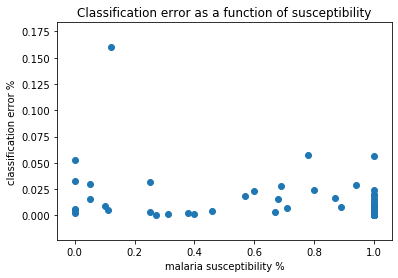

In [387]:
# error distribution by mice susceptibility
plt.scatter(x=y_train, y=cv_error)
plt.title("Classification error as a function of susceptibility")
plt.ylabel("classification error %")
plt.xlabel("malaria susceptibility %")

The error has been cosiderably reduces. We observe that for one mouse the error is significantly higher. It might be either because the given mouse has somewhat different relation between the gene expression and phenotype or due to gene expression measurement error.

In [389]:
pd.to_pickle(expression_full_susceptibility, "processed_data/expression_inferred.pkl")